# Neural Network image classfication using Keras/TensorFlow

In the code below, we start with a simple neural network to classify images. Using a convolution, pooling, dropout (and discarding image augmentation, multiple CNN layers, momentum and several other alternatives to standard gradient descent which did not improve the model) we improve the classification accuracy from 87% to 91%.

We also discuss next steps for improving accuracy further.

We'll start by importing libraries for TensorFlow and keras, and loading the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# fixing random seeds
from numpy.random import seed
seed(22)
from tensorflow import set_random_seed
set_random_seed(222)

print(tf.__version__)

#load fashion mnist dataset with 10 categories of clothing, in 28x28 images
fashion_mnist = keras.datasets.fashion_mnist

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#scale so pixels are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

C:\Users\gregorygsimon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


In [5]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Some of these class names are very similar visually (e.g. T-shirt/top vs shirt). Let's define a function to display the nth image along with its class to see examples of the images. 

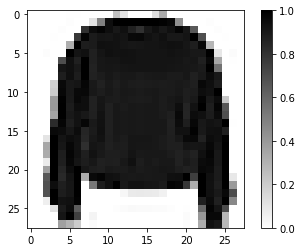

Pullover


In [6]:

def show_image_num(n):
    # display the nth image in grayscale along with the it's class name
    plt.figure()
    plt.imshow(train_images[n],cmap='gray_r')
    plt.colorbar()
    plt.grid(False)
    plt.show()
    print(class_names[train_labels[n]])

show_image_num(7)

Our baseline will be a very simple model taken from the [TensorFlow/keras documentation](https://www.tensorflow.org/tutorials/keras/basic_classification).

In [7]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 7s 122us/step - loss: 0.4938 - acc: 0.8250
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.3688 - acc: 0.8649
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.3350 - acc: 0.8773
Epoch 4/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.3093 - acc: 0.8858
Epoch 5/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.2934 - acc: 0.8915


In [51]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 25us/step
Test accuracy: 0.8714


The test accuracy of 0.872 being lower than the training accuracy of 0.89 suggests overfitting is already occuring. This will be our baseline accuracy to beat.

We'll try a Convolution Neural Network with pooling.

## CNN

In [2]:
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adadelta

# reshaping grayscale images to use with Conv2D
## list of images are of shape (n,28,28) but need to be shaped (n,28,28,1) for Conv2D
def add_dim(list_of_images):
    dim = list(list_of_images.shape)
    dim.append(1)
    return list_of_images.reshape(dim)

train_images_4d = add_dim(train_images)
test_images_4d = add_dim(test_images)

Using TensorFlow backend.


After some tinkering with parameters, we arrive at the model below. Notes:
* The quick overfitting was combatted best using **dropout**
* **multiple convolution layers** did not improve model, likely on account of the small size of the images (28 x 28)
* **image augmentation** (scaling, stretching, reflecting, etc.) to increase training set dramatically increased training time and reduced model accuracy.
    * because these images are already centered and rather uniform, image augmentation shouldn't be needed
    * the difference between a 'T-shirt' and a 'dress' or a 'shirt' are going to be subtle; image augmentation may destroy these subtleties
* The models take a long time to reach even 95% accuracy on the training set -- even with overfitting already occuring.
    * likely due to inherent similarities in these classes

In [3]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected layer
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#sgd = optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.5, nesterov=True)

model.compile(optimizer=Adadelta(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
__________

In [188]:
# model.save('single-CNN-128-dense-with-aug.h5') 
# 82s 44ms/step - loss: 0.5458 - acc: 0.7993 - val_loss: 0.4145 - val_acc: 0.8441

# model.save('single-CNN-256-dense-with-aug.h5')
# 88s 47ms/step - loss: 0.4557 - acc: 0.8319 - val_loss: 0.3780 - val_acc: 0.8587

# model.save('single-CNN-256-dense-no-aug.h5')
# 2nd epoch: 69s 1ms/step - loss: 0.2590 - acc: 0.9058 - val_loss: 0.2525 - val_acc: 0.9062

In [4]:
hist = model.fit(train_images_4d,train_labels,epochs=10,batch_size=50,validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 58s 1ms/step - loss: 0.6049 - acc: 0.8085 - val_loss: 0.3080 - val_acc: 0.8896
Epoch 2/10
42000/42000 [==============================] - 57s 1ms/step - loss: 0.3894 - acc: 0.8726 - val_loss: 0.2773 - val_acc: 0.9023
Epoch 3/10
42000/42000 [==============================] - 57s 1ms/step - loss: 0.3357 - acc: 0.8892 - val_loss: 0.2601 - val_acc: 0.9069
Epoch 4/10
42000/42000 [==============================] - 57s 1ms/step - loss: 0.3117 - acc: 0.8965 - val_loss: 0.2551 - val_acc: 0.9092
Epoch 5/10
42000/42000 [==============================] - 57s 1ms/step - loss: 0.2888 - acc: 0.9053 - val_loss: 0.2414 - val_acc: 0.9146
Epoch 6/10
42000/42000 [==============================] - 57s 1ms/step - loss: 0.2734 - acc: 0.9094 - val_loss: 0.2404 - val_acc: 0.9157
Epoch 7/10
42000/42000 [==============================] - 58s 1ms/step - loss: 0.2629 - acc: 0.9125 - val_loss: 0.2412 - val_acc

In [5]:
score = model.evaluate(x=test_images_4d, y=test_labels, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9135


#### Neural Network techniques for image classification improved model accuracy to 91% on test set, compared to Neural Network baseline of 87% accuracy.

* long training times due to using consumer CPU only.
* overfitting only began to appear near the 8th/9th epoch
* worth investigating difficult to reach high accuracy even on training set



## Investigating Misclassified Images


In [6]:
y_probs = model.predict(test_images_4d)           # probabilities assigned to test images 
y_preds = [np.argmax(probs) for probs in y_probs] # predictions (the class with highest probability)

# indices which were misclassified
bad_test_idxs = [i for i in range(len(y_preds)) if y_preds[i]!=test_labels[i]] 

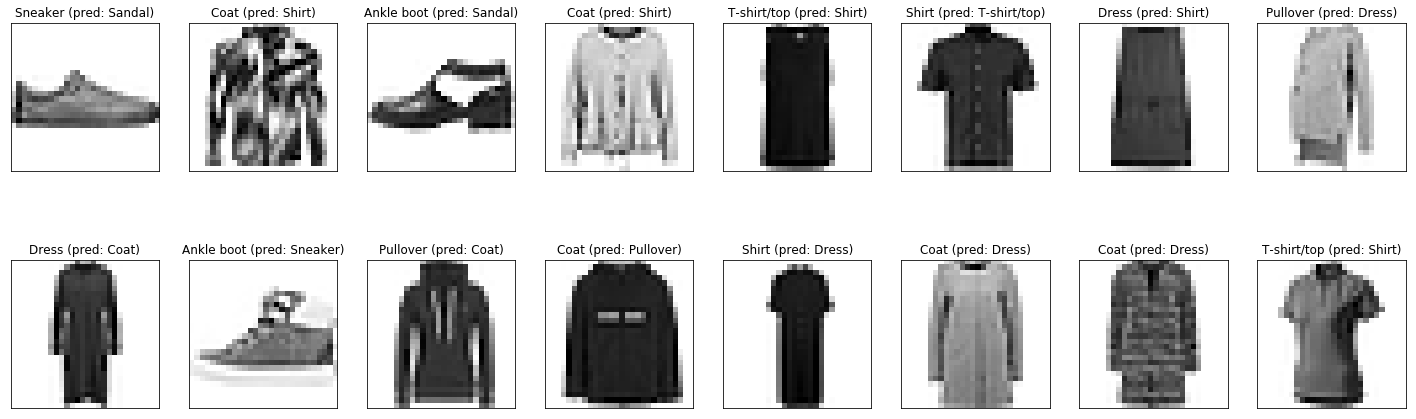

In [7]:
# Print 20 mislabeled examples
fig = plt.figure(figsize=(25,8))
for i, idx in enumerate(bad_test_idxs[:16]):
    ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[idx]),cmap='gray_r')
    ax.set_title("{} (pred: {})".format(class_names[test_labels[idx]], class_names[y_preds[idx]]))

We observe many of these classifications would be difficult for a human as well, for example the difference between a coat, pullover, shirt, t-shirt

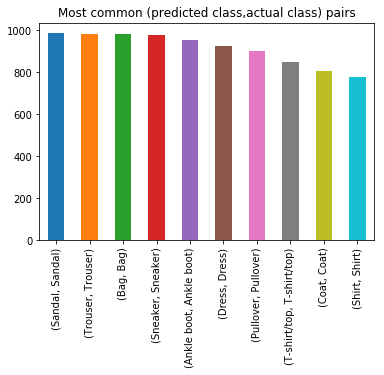

In [8]:
# create a Series of all pairs (predicted class, actual class)
import pandas as pd
pairs = pd.Series([(class_names[y_preds[i]],class_names[test_labels[i]]) for i in range(len(test_labels))])
# plot top pairs
pairs.sort_values().value_counts(sort=True).head(10).plot(
    kind='bar',title='Most common (predicted class,actual class) pairs'
)


The model does very well with Sandals, Trousers, Bags, and Sneakers, but did not match nearly as accurately for T-shirt/pullover/coat/and shirt

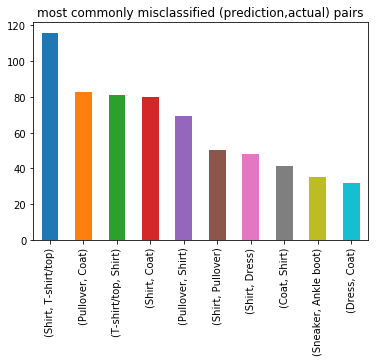

In [9]:
# by listing the pairs (predicted class,correct class) that were not the same,
# we can see the classes that the model most often confused
misclassified_pairs = pd.Series(
    [(class_names[y_preds[i]],class_names[test_labels[i]]) \
     for i in range(len(test_labels)) \
     if y_preds[i]!=test_labels[i]]
)
misclassified_pairs.sort_values().value_counts(sort=True).head(10).plot(
    kind='bar', title='most commonly misclassified (prediction,actual) pairs')

Of the 900 misclassified clothing images, more than half are due to mislabeling 'tops'. 

#### Next Steps
To further improve accuracy, train a separate NN on just classifying the different tops, and use this once this baseline model predicted any of the T-shirt/Shirt/Coat/Pullover

## appendix: image augmentation not effective

The code below shows that image augmentation (used often in image processing) is not effective here.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# create same model that previously reach 91% accuracy
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected layer
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adadelta(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# add a a generator for augmented images
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

train_generator = gen.flow(train_images_4d, train_labels, batch_size=32)
test_generator = test_gen.flow(test_images_4d, test_labels, batch_size=32)

model.fit_generator(train_generator, steps_per_epoch=60000//32, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//32)

Epoch 1/5
1875/1875 [==============================] - 88s 47ms/step - loss: 0.7728 - acc: 0.7286 - val_loss: 0.4200 - val_acc: 0.8494
Epoch 2/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.5726 - acc: 0.7983 - val_loss: 0.3751 - val_acc: 0.8666
Epoch 3/5
1875/1875 [==============================] - 85s 45ms/step - loss: 0.5328 - acc: 0.8138 - val_loss: 0.3520 - val_acc: 0.8764
Epoch 4/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.4990 - acc: 0.8258 - val_loss: 0.3896 - val_acc: 0.8600
Epoch 5/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.4832 - acc: 0.8330 - val_loss: 0.3433 - val_acc: 0.8764


at 80 seconds per epoch, the training time is significantly slower, and the change in loss/accuracy is slowing / halting. Let's run a few more epochs:

In [12]:
model.fit_generator(train_generator, steps_per_epoch=60000//32, epochs=3, 
                    validation_data=test_generator, validation_steps=10000//32)

Epoch 1/3
1875/1875 [==============================] - 82s 44ms/step - loss: 0.4677 - acc: 0.8374 - val_loss: 0.3149 - val_acc: 0.8901
Epoch 2/3
1875/1875 [==============================] - 83s 44ms/step - loss: 0.4534 - acc: 0.8438 - val_loss: 0.3418 - val_acc: 0.8825
Epoch 3/3
1875/1875 [==============================] - 83s 44ms/step - loss: 0.4484 - acc: 0.8455 - val_loss: 0.3449 - val_acc: 0.8798


In [13]:
score = model.evaluate(x=test_images_4d, y=test_labels, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.8795


After significantly longer training times, the accuracy is on par with our simplest model. Because the images are highly standardized (centered, angled upright, photographed from consistent angles) the benefits of image augmentation are minimal. Additionally, the subtle differences between pullover/shirt/t-shirt/dress may be lost when images are augmented.